In [1]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # return output
        pass

    def backward(self, output_gradient, learning_rate):
        # update parameters and return input gradient
        pass    

In [2]:
from Layer import Layer
import numpy as np

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(self.output_size, self.input_size)*np.sqrt(2./input_size) # He Weight Initialization
        self.bias = np.zeros((self.output_size, 1))

    def forward(self, input):
        _, self._m = input.shape
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate, lambd):
        weights_gradient = np.dot(output_gradient, self.input.T) / self._m
        weights_gradient += lambd * self.weights / self._m
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.sum(output_gradient, axis = 1, keepdims = True) / self._m
        return input_gradient

In [3]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation # a function
        self.activation_prime = activation_prime # a function

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0,x)

        def relu_prime(x):
            return np.where(x>0, 1, 0)

        super().__init__(relu, relu_prime)

In [4]:
def mse(Y_true, Y_pred):
    # it can be replaced just by one np.mean()
    return np.mean(np.mean(np.power(Y_pred - Y_true, 2), axis=0, keepdims=True))

def mse_prime(Y_true, Y_pred):
    n, _ = Y_true.shape
    return 2/n * (Y_pred - Y_true) #/ np.size(Y_true)

def binary_cross_entropy(Y_true, Y_pred, network, lambd):
    L2_regularization = 0
    for layer in network:
        if hasattr(layer, 'weights'):
            L2_regularization += np.sum(np.square(layer.weights))
    L2_regularization *= lambd/(2*np.size(Y_true))
    return -1 * np.mean(np.add(np.multiply(Y_true,np.log(Y_pred)) , np.multiply((1 - Y_true),np.log(1 - Y_pred)))) + L2_regularization

def binary_cross_entropy_prime(Y_true, Y_pred, network):
    return np.subtract(np.divide((1 - Y_true) , (1 - Y_pred)) , np.divide(Y_true , Y_pred)) #/ np.size(Y_true)

In [5]:
def predict(network, X):
    output = X
    for layer in network:
        output = layer.forward(output)
    return output

def accuracy(y_pred,y_true):
    acc = np.sum(np.logical_not(np.logical_xor((y_pred>0.5),y_true))) / np.size(y_true)*100
    print(f"Accuracy = {round(acc,2)} %")

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, lambd = 0.0001, verbose = True, mini_batch = None):
    losses = []
    mini_batches = []

    # dataset shuffling if mini-batch GD
    if mini_batch:
        n_x, m = x_train.shape
        # mini-batch amount
        if m % mini_batch:
            batches = int(m / mini_batch)
            last_batch = m % mini_batch
        else:
            batches = int(m / mini_batch)
            last_batch = 0

        concat = np.concatenate((x_train, y_train), axis=0)
        concat = concat.T
        concat = np.random.permutation(concat)
        concat = concat.T
        x_train = concat[0:n_x][:]
        y_train = concat[n_x][:].reshape(y_train.shape)

        for batch in range(batches):
            mini_batch_X = x_train[:, batch*mini_batch : (batch+1)*mini_batch]
            mini_batch_Y = y_train[:, batch*mini_batch : (batch+1)*mini_batch]
            mini_batches.append((mini_batch_X, mini_batch_Y))
        else:
            if last_batch:
                mini_batch_X = x_train[:, (batch+1)*mini_batch : (batch+1)*mini_batch+last_batch]
                mini_batch_Y = y_train[:, (batch+1)*mini_batch : (batch+1)*mini_batch+last_batch]
                mini_batches.append((mini_batch_X, mini_batch_Y))

        for e in range(epochs):
            for data in mini_batches:     
                x_train, y_train = data
                error = 0
                # forward
                output = predict(network, x_train)
                # error
                error = loss(y_train, output, network, lambd)
                losses.append(error)
        
                # backward
                grad = loss_prime(y_train, output, network)
                for layer in reversed(network):
                    if hasattr(layer, 'weights'):
                        grad = layer.backward(grad, learning_rate, lambd)
                    else:
                        grad = layer.backward(grad, learning_rate)
            
                if verbose:
                    if e%10000 == 0:
                        acc = np.sum(np.logical_not(np.logical_xor((output>0.5),y_train))) / np.size(y_train)*100
                        print(f"{e}/{epochs}, error = {error}, accuracy = {round(acc,2)} %")
                        #losses.append(error)
        return losses
    else:
        for e in range(epochs):
            error = 0
            # forward
            output = predict(network, x_train)
            # error
            error = loss(y_train, output, network, lambd)
            losses.append(error)
        
            # backward
            grad = loss_prime(y_train, output, network)
            for layer in reversed(network):
                if hasattr(layer, 'weights'):
                    grad = layer.backward(grad, learning_rate, lambd)
                else:
                    grad = layer.backward(grad, learning_rate)
            
            if verbose:
                if e%10000 == 0:
                    acc = np.sum(np.logical_not(np.logical_xor((output>0.5),y_train))) / np.size(y_train)*100
                    print(f"{e}/{epochs}, error = {error}, accuracy = {round(acc,2)} %")
                    #losses.append(error)
        return losses

In [12]:
def plot_decision_boundary(predict_function, network, X, Y):
    x_min, x_max = X[0, :].min()-1, X[0, :].max()+1 # x-axis
    y_min, y_max = X[1, :].min()-1, X[1, :].max()+1 # y-axis
    h = 0.05 # resolution
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # matrix of(xx - point along x axis, yy - points along y axis)
    net = np.c_[xx.ravel(), yy.ravel()].T
    # Predict the function value for the whole grid
    Z = predict_function(network, net)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap='jet')#, alpha = 0.75)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0,:], X[1,:], c=Y, cmap='jet')#, levels=100)
    plt.colorbar()
    plt.show()

In [21]:
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, cmap='jet');
    
    return train_X, train_Y, test_X, test_Y

(1, 100)

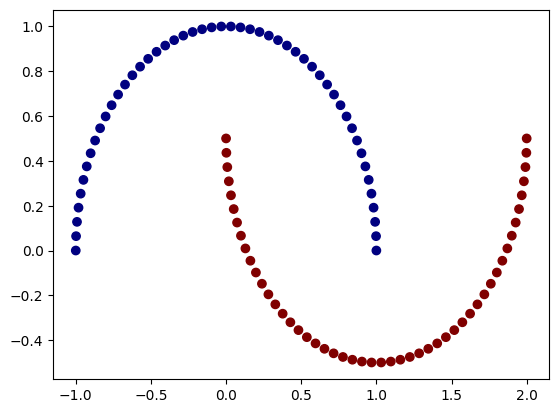

In [51]:
def load_make_moons():
    X, Y = make_moons(100)
    X = X.T
    Y = Y.reshape(1,100)
    plt.scatter(X[0, :], X[1, :], c=Y, cmap='jet');

    return X, Y

X, Y = load_make_moons()
Y.shape

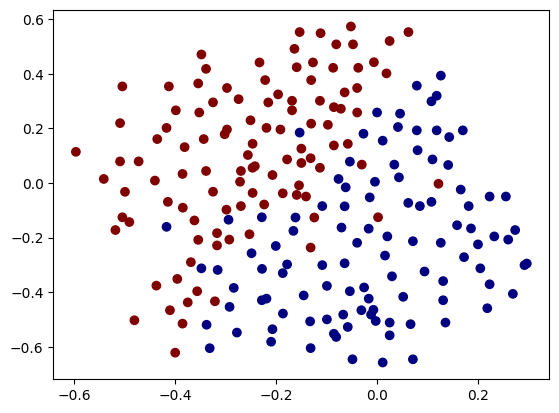

In [22]:
X, Y, test_X, test_Y = load_2D_dataset()

In [52]:
network = [
    Dense(2, 20),
    ReLU(),
    Dense(20, 3),
    ReLU(),
    Dense(3, 1),
    Sigmoid()
]
#print(train_Y)
losses = train(network, binary_cross_entropy, binary_cross_entropy_prime, X, Y, epochs = 30000, learning_rate=0.3, lambd=0.9, mini_batch = 64)
#out = predict(network, test_X)
#accuracy(out, test_Y)

m 100
0/30000, error = 1.644173045285251, accuracy = 39.06 %
0/30000, error = 1.5715941185627558, accuracy = 50.0 %
10000/30000, error = 0.2336772559999749, accuracy = 98.44 %
10000/30000, error = 0.36286750524336103, accuracy = 100.0 %
20000/30000, error = 0.23347947995184418, accuracy = 98.44 %
20000/30000, error = 0.3628466088369785, accuracy = 100.0 %


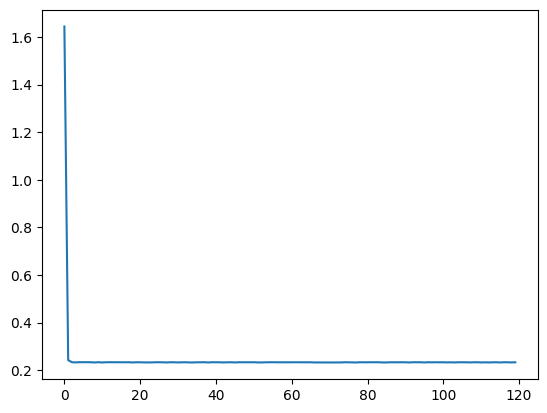

In [53]:
plt.plot(losses[::500])

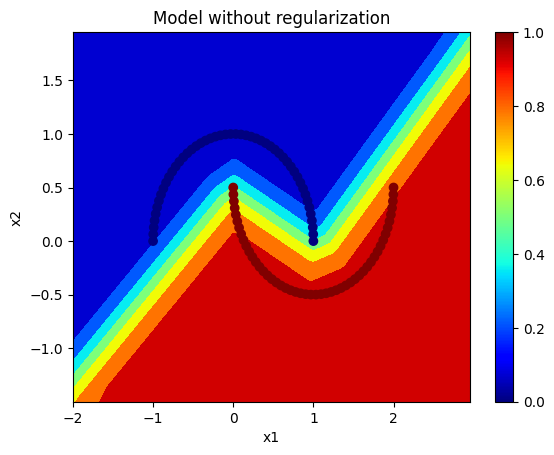

In [55]:
plt.title("Model without regularization")
axes = plt.gca()
#axes.set_xlim([-0.75,0.40])
#axes.set_ylim([-0.75,0.65])
plot_decision_boundary(predict, network, X, Y)